#### Library imports 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import owslib.fes as fes
from owslib.etree import etree
from owslib.wfs import WebFeatureService
import shutil
import os
import zipfile
import folium
from shapely.geometry import box

# Data Visualisation and exploration Tutorial

This Notebook is a tutorial on how to access, store, reproject and visualise 1) Zarr Bathymetric dataset from the EMODNet STAC Catalogue and 2) A vector dataset from the EMODnet Human Activities Catalogue and within an EDITO Service.

Furthermore, a brief overview of statistical analysis and data storage is given at the end of the tutorial.

### Raster Bathymetric basemap access and initial inspection

Defining Data source and region of interest variables

In [2]:
#Path to Bathymetric dataset
host= 'https://s3.waw3-1.cloudferro.com'
bucket = 'emodnet'
arco_location = 'bathymetry/bathymetry_2022.zarr'

# Define bounding boxes for your desired region within European waters 
region = 'North Sea' 
bbox = [-2, 8, 50, 60]

In [3]:
# open dataset
dataset = xr.open_dataset(f"{host}/{bucket}/{arco_location}", engine='zarr')
dataset.attrs

# Inspect the Elevation data 
elevation_data_array = dataset.data_vars['elevation']
print(elevation_data_array)

<xarray.DataArray 'elevation' (latitude: 72000, longitude: 75840)> Size: 22GB
[5460480000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 576kB 15.0 15.0 15.0 15.0 ... 90.0 90.0 90.0
  * longitude  (longitude) float64 607kB -36.0 -36.0 -36.0 ... 43.0 43.0 43.0
Attributes:
    grid_mapping:        crs
    long_name:           Elevation relative to sea level
    max:                 598.0
    min:                 -6912.60693359375
    sdn_parameter_name:  Sea-floor height (above Lowest Astronomical Tide dat...
    sdn_parameter_urn:   SDN:P01::HGHTALAT
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       geoid_height_above_reference_ellipsoid
    units:               m


### Open and Plot the Bathymetry raster data
Below we create an initial map of the bathymetry of the North Sea which will serve as our region of interest in this example. 

In [4]:
# Subset the dataset within the specified bounding box
subset_dataset = dataset.sel(latitude=slice(bbox[2], bbox[3]), longitude=slice(bbox[0], bbox[1]))
elevation_data_subset = subset_dataset['elevation']
print(elevation_data_subset)                                                                        # Inspect the 'Elevation' data slice (subset)


<xarray.DataArray 'elevation' (latitude: 9600, longitude: 9600)> Size: 369MB
[92160000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 77kB 50.0 50.0 50.0 50.0 ... 60.0 60.0 60.0
  * longitude  (longitude) float64 77kB -1.999 -1.998 -1.997 ... 7.998 7.999
Attributes:
    grid_mapping:        crs
    long_name:           Elevation relative to sea level
    max:                 598.0
    min:                 -6912.60693359375
    sdn_parameter_name:  Sea-floor height (above Lowest Astronomical Tide dat...
    sdn_parameter_urn:   SDN:P01::HGHTALAT
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       geoid_height_above_reference_ellipsoid
    units:               m


/opt/mamba/envs/EDITOenv/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


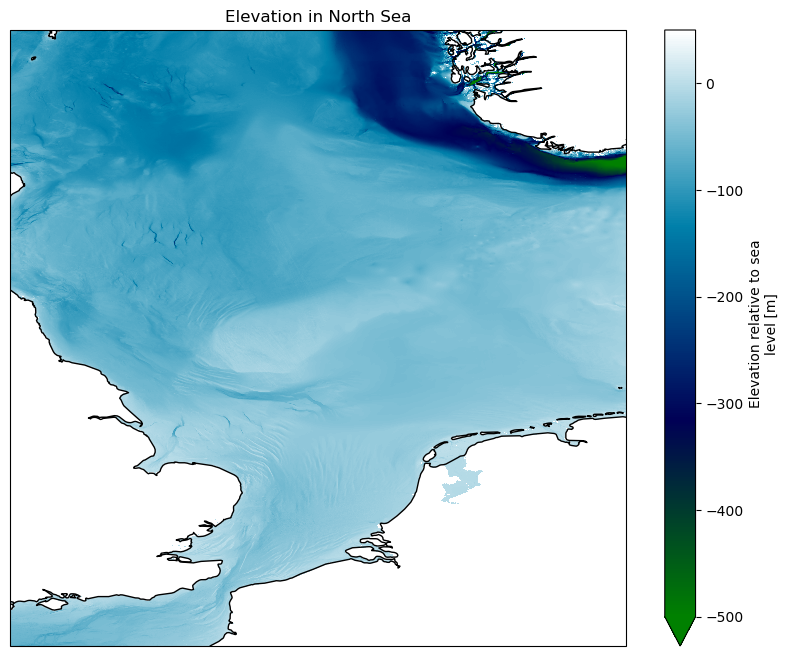

In [5]:
# Create a map using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([bbox[0], bbox[1], bbox[2], bbox[3]])

# Plot elevation data, specifying the color bar range and colormap
elevation_data_subset.plot(cmap = 'ocean', vmin=-500, vmax=50)  
plt.title(f"Elevation in {region}")

#Save the figure locally 
#plt.savefig(f'{region}_DTM.tif')                                                                   # Uncomment and specify your desired file location and name
plt.show()

Now, lets dive deeper into the interesting data. In this example we will access a vector dataset (a shapefile) of the Windfarm projects in the North Sea from the EMODNet Human Activities Catalogue. 

In particular, we will look into:
1. Where and how to access it.
2. How to download a compressed version of the shapefile and unpack it.
3. Reproject the data to a desired EPSG using geopandas.
4. Plotting the Windfarm shapefile as an overlay of the Bathymetry raster for static visualisation
5. Create an Interactive map of the Geodataframe
6. Statistical analysis of the dataset
7. Visualising Country statistics as Pie Charts

### 1. Loading and inspecting Vector data from EMODnet

In [6]:
# Define Variables

downloads_dir = 'dld_dir'
dataset = 'emodnet:windfarmspoly'

zip_shapefile = 'dld_dir/shapefile.zip'
extracted_dir = 'dld_dir/shapefile'
output_shapefile ='dld_dir/shapefile/windfarmspolyPolygon.shp'


In [7]:
# Create Directory to download the Vector data

os.makedirs(downloads_dir, exist_ok=True) #Local on the service

#Connect to the EMODnet Human Activities WebFeatureService and Inspect
wfs = WebFeatureService('https://ows.emodnet-humanactivities.eu/wfs', version = '1.1.0')
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
GeoServer Web Feature Service
This is the reference implementation of WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


In [8]:
# OPTIONAL: Inspect available datasets 
list(wfs.contents)

['emodnet:activelicenses',
 'emodnet:advisorycouncils',
 'emodnet:aquaculture',
 'emodnet:baltic',
 'emodnet:blacksea',
 'emodnet:longdistancefleet',
 'emodnet:market',
 'emodnet:mediterranean',
 'emodnet:northsea',
 'emodnet:northwesternwaters',
 'emodnet:outermostregions',
 'emodnet:pelagicstocks',
 'emodnet:southwesternwaters',
 'emodnet:aggregateareas',
 'emodnet:aggregates',
 'emodnet:fishingbeamtrawls',
 'emodnet:fishingbottomottertrawls',
 'emodnet:fishingbottomseines',
 'emodnet:fishingdredges',
 'emodnet:fishingpelagic',
 'emodnet:fishingstaticgears',
 'emodnet:fishingsubsurface',
 'emodnet:fishingsurface',
 'emodnet:barcelona',
 'emodnet:hydrocarbons',
 'emodnet:bucharest',
 'emodnet:desalination',
 'emodnet:dischargepoints',
 'emodnet:dredgespoil',
 'emodnet:dredgespoilpoly',
 'emodnet:dredging',
 'emodnet:munitions',
 'emodnet:munitionspoly',
 'emodnet:emeraldnetwork',
 'emodnet:faoareas',
 'emodnet:finfish',
 'emodnet:fishsales',
 'emodnet:divisioncatches',
 'emodnet:major

### Define desired vector dataset
Lets inspect the Windfarms Polygons dataset which is a dataset of Windfarm projects in European waters.

In [9]:
#Inspect Windfarm polygons dataset
print(wfs.contents[dataset].title)
print(wfs.contents[dataset].abstract)

Wind Farms (Polygons)
The dataset on offshore wind farms in the European seas was created in 2014 by CETMAR for the European Marine Observation and Data Network (EMODnet). It is the result of the aggregation and harmonization of datasets provided by several sources. It is updated every year and it is available for viewing and download on EMODnet web portal (Human Activities, https://emodnet.ec.europa.eu/en/human-activities). The dataset contains points and/or (where available) polygons representing offshore wind farms in the following countries: Belgium, Denmark, Estonia, Finland, France, Germany, Greece, Ireland, Italy, Latvia, Lithuania, Netherlands, Norway, Poland, Portugal, Spain, Sweden and United Kingdom. Each point and polygon has the following attributes (where available): Name, Nº of turbines, Status (Approved, Planned, Dismantled, Construction, Production, Test site), Country, Year, Power (MW), Distance to coast (metres) and Area (square kilometres). The distance to coast (EE

#### Inspect the GeoJSON file by loading it into a geodataframe

In [10]:
response = wfs.getfeature(typename=dataset,
                          bbox=(bbox), #subset to the Study area ( based on bbox params)
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'dld_dir/{dataset.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'dld_dir/{dataset.replace(":","_")}.json')
gdf

,id,country,name,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,windfarmspoly.1,Sweden,Stora Middelgrund,108.0,864.0,Planned,None,24805.731113,59.826131,None,"MULTIPOLYGON (((12.03532 56.65295, 12.06134 56..."
1,windfarmspoly.2,Sweden,Lovstaviken,5.0,11.5,Production,None,0.000000,0.193854,None,"MULTIPOLYGON (((12.4671 56.89015, 12.47244 56...."
2,windfarmspoly.3,Sweden,Kattegatt Offshore,50.0,282.0,Approved,None,6381.649369,22.111037,None,"MULTIPOLYGON (((12.33361 56.86036, 12.34738 56..."
3,windfarmspoly.54,Denmark,Nissum Bredning,4.0,28.0,Production,2018,552.097064,1.033175,None,"MULTIPOLYGON (((8.23407 56.67252, 8.25175 56.6..."
4,windfarmspoly.55,Denmark,Horns Rev II,91.0,209.3,Production,2009,28725.073617,31.377920,None,"MULTIPOLYGON (((7.59319 55.64797, 7.59999 55.6..."
...,...,...,...,...,...,...,...,...,...,...,...
362,windfarmspoly.550,United Kingdom,Cenos,NaN,1350.0,Planned,None,187805.564816,332.902030,None,"MULTIPOLYGON (((1.4023 57.25235, 1.48642 57.20..."
363,windfarmspoly.559,United Kingdom,Salamander,NaN,100.0,Planned,None,33007.263264,33.243360,None,"MULTIPOLYGON (((-1.12492 57.61557, -1.20533 57..."
364,windfarmspoly.551,United Kingdom,Culzean,NaN,3.0,Planned,None,221021.383044,2.001045,None,"MULTIPOLYGON (((1.87627 57.19864, 1.87668 57.1..."
365,windfarmspoly.552,United Kingdom,Judy,NaN,15.0,Planned,None,259624.252434,8.045883,None,"MULTIPOLYGON (((2.27045 56.6704, 2.27103 56.67..."


###  2. Store and unpack compressed (.zip) datasets

In [11]:
# Create temporary directories
os.makedirs(extracted_dir, exist_ok=True)

# Download and save the shapefile zip
response = wfs.getfeature(typename=dataset, outputFormat='SHAPE-ZIP')
with open(zip_shapefile, 'wb') as temp_file:
    shutil.copyfileobj(response, temp_file)

# Extract the zip file
with zipfile.ZipFile(zip_shapefile, 'r') as zip_ref:
    extracted_files = zip_ref.namelist()
    print(extracted_files)
    # Check if the output shapefile already exists before extraction
    if not os.listdir(extracted_dir):
        zip_ref.extractall(extracted_dir)
    
# Read the GeoDataFrame from the extracted Shapefile
Study_area = gpd.read_file(output_shapefile)
Study_area

#Remove the .zip to free space
os.remove(zip_shapefile) 


['windfarmspolyPolygon.shx', 'windfarmspolyPolygon.shp', 'windfarmspolyPolygon.cst', 'windfarmspolyPolygon.prj', 'windfarmspolyPolygon.dbf']


### 3. Reproject to the correct CRS

Here we reproject the shapefile to the correct coordinate reference system using the `geopandas.to_crs`. Although for this dataset, the CRS was probably already set to begin with, it is a good habit to ensure that the dataset CRS is correct either by inspecting it: `Study_area.crs` or by setting it manually: `Study_area.to_crs`.


In [12]:
Study_area.to_crs(4326)
Study_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 4. Plotting the Windfarm shapefile as an overlay of the Bathymetry raster for static visualisation

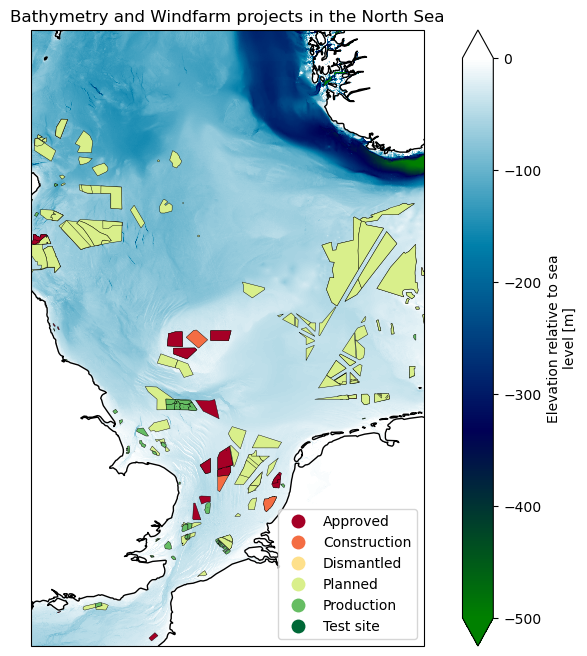

CPU times: user 1min 4s, sys: 37.4 s, total: 1min 41s
Wall time: 1min 42s


In [13]:
%%time

# Plot on a map using Cartopy
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([bbox[0], bbox[1], bbox[2], bbox[3]])

# Plot elevation data with specific color bar range
elevation_data_subset.plot(cmap='ocean', vmin=-500, vmax=0, ax=ax)  # Set color bar range from 0 to 500 meters
# Plot the GeoDataFrame
gdf.plot(column='status',                                       # Specify the column in which the data you need to plot is located
         categorical=False,
         cmap='RdYlGn',
         legend=True,
         legend_kwds={'loc': 'lower right'},
         alpha=1,
         edgecolor = 'black', 
         linewidth = 0.3,
         ax=ax) 

plt.title(f"Bathymetry and Windfarm projects in the {region}")

#Save the figure locally 
#plt.savefig(f'{region}.tif')
plt.show()


### 5. Create an Interactive map of the Geodataframe

In [14]:
gdf.explore(column ='status', cmap = 'RdYlGn', popup = True)


### 6.Statistical analysis of the dataset

In [15]:
# Group by 'status' and calculate the total area, number of turbines, and power output
status_grouped = gdf.groupby('status').agg(
    total_area_sqkm=pd.NamedAgg(column='area_sqkm', aggfunc='sum'),
    total_turbines=pd.NamedAgg(column='n_turbines', aggfunc='sum'),
    total_power_output_Mw=pd.NamedAgg(column='power_mw', aggfunc='sum')
).reset_index()

# Calculate percentages for each column in the status_grouped DataFrame
total_area_sum = status_grouped['total_area_sqkm'].sum()
total_turbines_sum = status_grouped['total_turbines'].sum()
total_power_output_sum = status_grouped['total_power_output_Mw'].sum()

status_grouped['area_percentage'] = (status_grouped['total_area_sqkm'] / total_area_sum) * 100
status_grouped['turbines_percentage'] = (status_grouped['total_turbines'] / total_turbines_sum) * 100
status_grouped['power_output_percentage'] = (status_grouped['total_power_output_Mw'] / total_power_output_sum) * 100

status_grouped = status_grouped.round({
    'total_area_sqkm': 1,
    'total_turbines': 1,
    'total_power_output_Mw': 1,
    'area_percentage': 1,
    'turbines_percentage': 1,
    'power_output_percentage': 1
})

print("Total Area, Number of Turbines, and Power Output per Status with Percentages")
status_grouped

Total Area, Number of Turbines, and Power Output per Status with Percentages


,status,total_area_sqkm,total_turbines,total_power_output_Mw,area_percentage,turbines_percentage,power_output_percentage
0,Approved,9322.4,1692.0,30222.6,9.5,17.5,19.7
1,Construction,3988.6,1361.0,15607.2,4.1,14.1,10.2
2,Dismantled,0.8,5.0,4.0,0.0,0.1,0.0
3,Planned,79985.4,1128.0,79293.5,81.3,11.7,51.8
4,Production,5102.3,5474.0,27962.5,5.2,56.7,18.3
5,Test site,5.9,0.0,55.0,0.0,0.0,0.0


In [16]:
# Group by 'country' and calculate the total area, number of turbines, and power output
country_grouped = gdf.groupby('country').agg(
    total_area_sqkm=pd.NamedAgg(column='area_sqkm', aggfunc='sum'),
    total_turbines=pd.NamedAgg(column='n_turbines', aggfunc='sum'),
    total_power_output_Mw=pd.NamedAgg(column='power_mw', aggfunc='sum')
).reset_index()

# Calculate percentages for each column in the country_grouped DataFrame
total_area_sum = country_grouped['total_area_sqkm'].sum()
total_turbines_sum = country_grouped['total_turbines'].sum()
total_power_output_sum = country_grouped['total_power_output_Mw'].sum()

country_grouped['area_percentage'] = (country_grouped['total_area_sqkm'] / total_area_sum) * 100
country_grouped['turbines_percentage'] = (country_grouped['total_turbines'] / total_turbines_sum) * 100
country_grouped['power_output_percentage'] = (country_grouped['total_power_output_Mw'] / total_power_output_sum) * 100

country_grouped = country_grouped.round({
    'total_area_sqkm': 1,
    'total_turbines': 1,
    'total_power_output_Mw': 1,
    'area_percentage': 1,
    'turbines_percentage': 1,
    'power_output_percentage': 1
})

print("\nTotal Area, Number of Turbines, and Power Output per Country with Percentages")
country_grouped


Total Area, Number of Turbines, and Power Output per Country with Percentages


,country,total_area_sqkm,total_turbines,total_power_output_Mw,area_percentage,turbines_percentage,power_output_percentage
0,Belgium,172.0,448.0,2421.0,0.2,4.6,1.6
1,Denmark,33173.1,671.0,7043.9,33.7,6.9,4.6
2,Estonia,1781.3,0.0,0.0,1.8,0.0,0.0
3,Finland,2488.7,0.0,0.0,2.5,0.0,0.0
4,France,2967.2,197.0,8376.0,3.0,2.0,5.5
5,Germany,7545.2,2083.0,22590.0,7.7,21.6,14.8
6,Latvia,1648.5,0.0,0.0,1.7,0.0,0.0
7,Lithuania,1208.3,0.0,700.0,1.2,0.0,0.5
8,Netherlands,8016.3,1223.0,18153.0,8.1,12.7,11.9
9,Poland,2310.6,0.0,0.0,2.3,0.0,0.0


### 7. Visualising Country statistics as Pie Charts

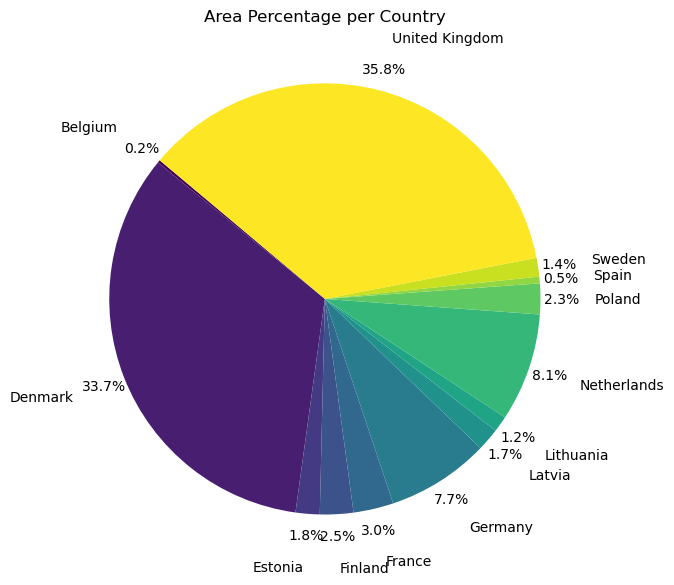

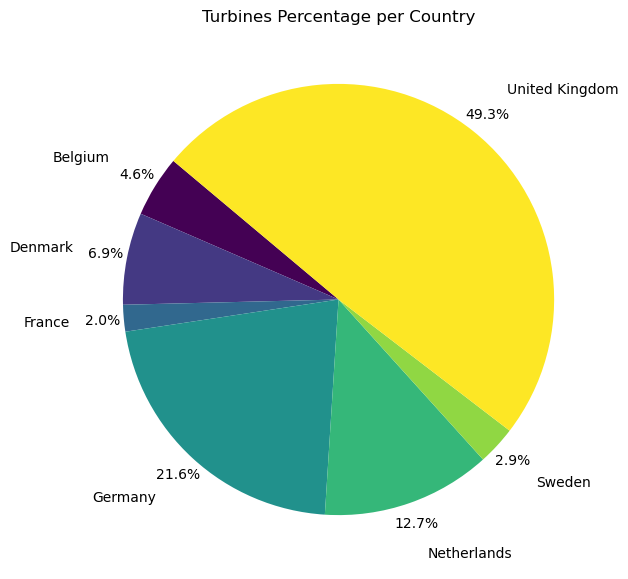

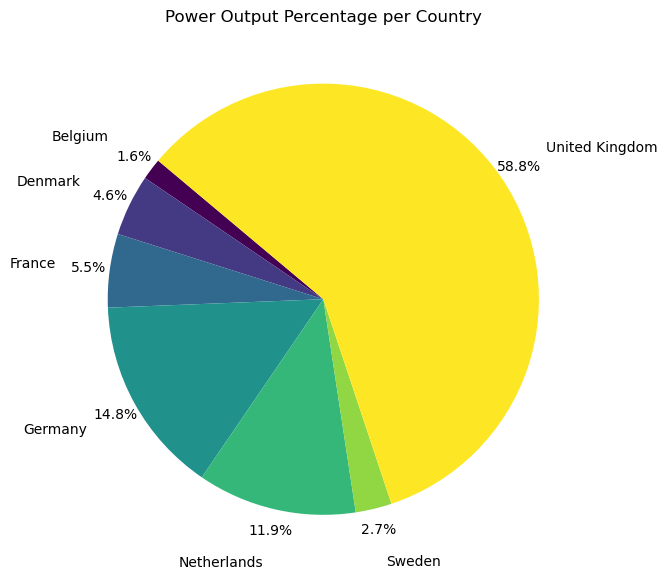

In [17]:
# Pie Chart for Area Percentage (ommitting countries with 0%)
filtered_country_grouped = country_grouped[country_grouped['area_percentage'] > 0]

plt.figure(figsize=(10, 7))
plt.pie(filtered_country_grouped['area_percentage'], labels=filtered_country_grouped['country'], autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis(np.linspace(0, 1, len(filtered_country_grouped))), pctdistance=1.1, labeldistance=1.25)
plt.title('Area Percentage per Country')
plt.show()

# Pie Chart for Turbines Percentage (ommitting countries with 0%)
f_turb_country_grouped = country_grouped[country_grouped['turbines_percentage'] > 0]

plt.figure(figsize=(10, 7))
plt.pie(f_turb_country_grouped['turbines_percentage'], labels=f_turb_country_grouped['country'], autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis(np.linspace(0, 1, len(f_turb_country_grouped))), pctdistance=1.1, labeldistance=1.25)
plt.title('Turbines Percentage per Country')
plt.show()

# Pie Chart for Power Output Percentage (ommitting countries with 0%)
f_power_country_grouped = country_grouped[country_grouped['turbines_percentage'] > 0]

plt.figure(figsize=(10, 7))
plt.pie(f_power_country_grouped['power_output_percentage'], labels=f_power_country_grouped['country'], autopct='%1.1f%%', startangle=140, colors=plt.cm.viridis(np.linspace(0, 1, len(f_power_country_grouped))), pctdistance=1.1, labeldistance=1.25)
plt.title('Power Output Percentage per Country')
plt.show()

## Storing the Visualisations and Analysis results In EDITO S3 buckets

 ### Connect to EDITO Storage
 Adjust the credentials and filepaths (all the strings)

```
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.dive.edito.eu'},
    key = os.environ["YOUR_ACCESS_KEY_ID"], 
    secret = os.environ["_YOUR_SECRET_ACCESS_KEY"], 
    token = os.environ["YOUR_SESSION_TOKEN"])



```
bucket_name = 'YOUR_BUCKET_NAME'
folder_name = 'NAME_OF_FOLDERS_TO_BE_ACCESSED'
BUCKET = f'{bucket_name}/{folder_name}/'
local_directory = 'your\local\directory/' # or: /home/onyxia/work for local dir on the service

fs.ls(BUCKET)                             # list files present in S3 BUCKET
```

### Run EITHER one OR the other 
fs.get to copy files from S3 onto VM
fs.put to copy files from local (or VM) into S3

Always do a get when starting a VM

```
# download files from S3 bucket to local
fs.get(BUCKET, '/home/onyxia/work/', recursive=True, exist_ok = True)
```

```
# Upload file to S3 bucket
fs.put(local_directory, BUCKET, recursive=True)
```
